# Jump-Start Training with Transfer Learning

An interesting benefit of deep learning neural networks is that they can be reused on related problems. In deep learning, this means reusing the weights in one or more layers from a pre-trained network model in a new model and keeping the weights fixed, fine-tuning them, or adapting the weights entirely when training the model. Transfer learning refers to a technique for predictive modeling on a different but somehow similar problem that can then be reused partly or wholly to accelerate the training and improve the performance of a model on the problem of interest. In this tutorial, you will discover how to use transfer learning to improve the performance of deep learning neural networks in Python with Keras. After completing this tutorial, you will know:

* Transfer learning is a method for reusing a model trained on a related predictive modeling problem.
* Transfer learning can accelerate the training of neural networks as either a weight initialization scheme or feature extraction method.
* How to use transfer learning to improve the performance of an MLP for a multiclass classification problem.

## Transfer Learning

Transfer learning generally refers to a process where a model trained on one problem is used in some way on a second related problem.

In deep learning, transfer learning is a technique whereby a neural network model is first trained on a problem similar to the problem that is being solved. One or more layers from the trained model are then used in a new model trained on the problem of interest.

Transfer learning has the benefit of decreasing the training time for a neural network model, resulting in lower generalization error. There are two main approaches to implementing transfer learning; they are:

* Weight Initialization.
* Feature Extraction.

The weights in re-used layers may be used as the starting point for the training process and adapted to the new problem. This usage treats transfer learning as a type of weight initialization scheme. This may be useful when the first related problem has a lot more labeled data than the problem of interest, and the similarity in the structure of the problem may be useful in both contexts.

Alternately, the network's weights may not be adapted to the new problem, and only new layers after the reused layers may be trained to interpret their output. This usage treats transfer learning as a type of feature extraction scheme. An example of this approach is re-using deep convolutional neural network models trained for photo classification as feature extractors when developing photo captioning models. Variations on these usages may involve not initially training the model's weights on the new problem but later fine-tuning all weights of the learned model with a small learning rate.

## Transfer Learning Case Study

This section will demonstrate how to use transfer learning to develop MLP models on a multiclass classification problem. This example provides a template for applying transfer learning to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate transfer learning. The scikit-learn class provides the make blobs() function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We can configure the problem to have two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [2]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=1)

The results are the input and output elements of a dataset that we can model. The random state argument can be varied to give different versions of the problem (different cluster centers). We can use this to generate samples from two different problems: train a model on one problem and re-use the weights to learn a model for a second problem better. Specifically, we will refer to random state=1 as Problem 1 and random state=2 as Problem 2.

* Problem 1. Blobs problem with two input variables and three classes with the random state argument set to one.
* Problem 2. Blobs problem with two input variables and three classes with the random state argument set to two.

To get a feeling for the complexity of the problem, we can plot each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

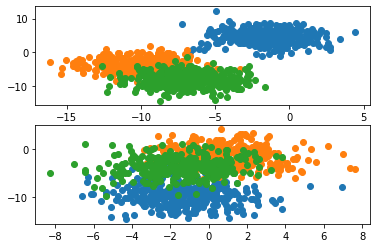

In [3]:
# plot of blobs multiclass classification problems 1 and 2
from sklearn.datasets import make_blobs
from numpy import where
from matplotlib import pyplot

# generate samples for blobs problem with a given random seed
def samples_for_seed(seed):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    
    return X, y

# create a scatter plot of points colored by class value
def plot_samples(X, y, classes=3):
    # plot points for each class
    for i in range(classes):
        # select indices of points with each class label
        samples_ix = where(y == i)
        
        # plot points for this class with a given color
        pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1])

# generate multiple problems
n_problems = 2
for i in range(1, n_problems+1):
    # specify subplot
    pyplot.subplot(210 + i)
    
    # generate samples
    X, y = samples_for_seed(i)
    
    # scatter plot of samples
    plot_samples(X, y)

# plot figure
pyplot.show()

Running the example generates a sample of 1,000 examples for Problem 1 and Problem 2 and creates a scatter plot for each sample, coloring the data points by their class value.

This provides a good basis for transfer learning as each version of the problem has similar input data with a similar scale, although with different target information (e.g., cluster centers). We would expect that aspects of a model fit on one version of the blobs problem (e.g., Problem 1) to be useful when fitting a model on a new version of the blobs problem (e.g., Problem 2).

### Multilayer Perceptron Model for Problem 1

In this section, we will develop a Multilayer Perceptron model (MLP) for Problem 1 and save the model to file so that we can reuse the weights later. First, we will develop a function to prepare the dataset for modeling. After the make blobs() function is called with a given random seed (e.g., one in this case for Problem 1), the target variable must be one hot encoded so that we can develop a model that predicts the probability of a given sample belonging to each of the target classes. The samples for seed() function below implements this, preparing the dataset for a given random number generator seed and retuning the train and test sets split into input and output components. The prepared samples can then be split in half, with 500 examples for the train and test datasets.

In [6]:
from tensorflow.keras.utils import to_categorical

# prepare a blobs examples with a given random seed
def samples_for_seed(seed):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    
    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]

    return trainX, trainy, testX, testy

We can call this function to prepare a dataset for Problem 1 as follows.

In [7]:
# prepare data
trainX, trainy, testX, testy = samples_for_seed(1)

Next, we can define and fit a model on the training dataset. The model will expect two inputs for the two variables in the data. The model will have two hidden layers with five nodes each and the rectified linear activation function. Two layers are probably not required for this function, although we're interested in the model learning some deep structure that we can reuse across instances of this problem. The output layer has three nodes, one for each class in the target variable and the softmax activation function.

In [9]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# define model
model = Sequential()
model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

Given that the problem is a multiclass classification problem, the categorical cross-entropy loss function is minimized, and the stochastic gradient descent with the default learning rate and no momentum is used to learn the problem.

In [10]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

The model is fit for 100 epochs on the training dataset, and the test set is used as a validation dataset during training, evaluating the performance on both datasets at the end of each epoch to plot learning curves.

The fit model() function ties these elements together, taking the train and test datasets as arguments and returning the fit model and training history.

In [11]:
# define and fit model on a training dataset
def fit_model(trainX, trainy, testX, testy):
    # define model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

    return model, history

We can call this function with the prepared dataset to obtain a fit model and the history collected during the training process.

In [12]:
# fit model on train dataset
model, history = fit_model(trainX, trainy, testX, testy)

Finally, we can summarize the performance of the model. The classification accuracy of the model on the train and test sets can be evaluated.

In [13]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.916, Test: 0.926


The history collected during training can be used to create line plots showing both the loss and classification accuracy for the model on the train and test sets over each training epoch, providing learning curves.

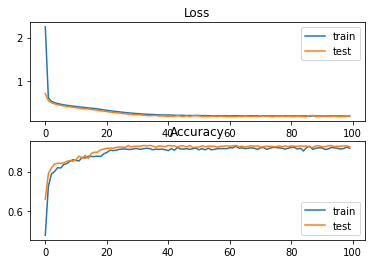

In [15]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The summarize model() function below implements this, taking the fit model, training history, and dataset as arguments are printing the model performance and creating a plot of model learning curves.

In [18]:
# summarize the performance of the fit model
def summarize_model(model, history, trainX, trainy, testX, testy):
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # plot loss during training
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    
    pyplot.show()

We can call this function with the fit model and prepared data.

Train: 0.916, Test: 0.926


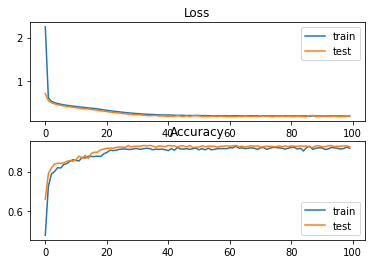

In [19]:
# evaluate model behavior
summarize_model(model, history, trainX, trainy, testX, testy)

At the end of the run, we can save the model to file so that we may load it later and use it to transfer learning experiments. Note that saving the model to file requires that you have the h5py library installed. This library can be installed via pip as follows:

`sudo pip install h5py`

The fit model can be saved by calling the save() function on the model.

In [20]:
# save model to file
model.save('model.h5')

Tying these elements together, the complete example of fitting an MLP on Problem 1, summarizing the model's performance, and saving the model to file is listed below.

In [24]:
# fit mlp model on problem 1 and save model to file
from sklearn.datasets import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

# prepare a blobs examples with a given random seed
def samples_for_seed(seed):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    
    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    
    return trainX, trainy, testX, testy

# define and fit model on a training dataset
def fit_model(trainX, trainy, testX, testy):
    # define model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

    return model, history

# summarize the performance of the fit model
def summarize_model(model, history, trainX, trainy, testX, testy):
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # plot loss during training
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()

    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    
    pyplot.show()

# prepare data
trainX, trainy, testX, testy = samples_for_seed(1)

# fit model on train dataset
model, history = fit_model(trainX, trainy, testX, testy)

Running the example fits and evaluates the model's performance, printing the classification accuracy on the train and test sets.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model performed well on Problem 1, achieving a classification accuracy of about 92% on both the train and test datasets.

A figure is also created summarizing the learning curves of the model, showing both the loss (top) and accuracy (bottom) for the model on both the train (blue) and test (orange) datasets at the end of each training epoch. In this case, we can see that the model learned the problem reasonably quickly and well, perhaps converging in about 40 epochs and remaining reasonably stable on both datasets.

Train: 0.924, Test: 0.922


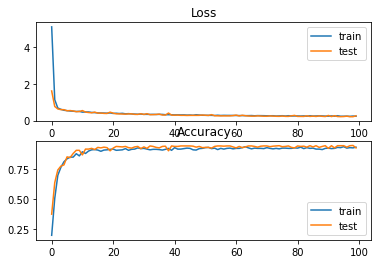

In [25]:
# evaluate model behavior
summarize_model(model, history, trainX, trainy, testX, testy)

# save model to file
model.save('model.h5')

Now that we have seen how to develop a standalone MLP for the blobs Problem 1, we can do the same for Problem 2 that can be used as a baseline.

### Standalone MLP Model for Problem 2

The example in the previous section can be updated to fit an MLP model to Problem 2. It is important to get an idea of performance and learning dynamics on Problem 2 for a standalone model first, as this will provide a baseline in performance that can be used to compare to a model fit on the same problem using transfer learning. A single change is required that changes the call to samples for seed() to use the pseudorandom number generator seed of two instead of one.

In [26]:
# prepare data
trainX, trainy, testX, testy = samples_for_seed(2)

For completeness, the full example of this change is listed below.

In [29]:
# fit mlp model on problem 2 and save model to file
from sklearn.datasets import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

# prepare a blobs examples with a given random seed
def samples_for_seed(seed):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)

    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]

    return trainX, trainy, testX, testy

# define and fit model on a training dataset
def fit_model(trainX, trainy, testX, testy):
    # define model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
    
    return model, history

# summarize the performance of the fit model
def summarize_model(model, history, trainX, trainy, testX, testy):
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # plot loss during training
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    
    pyplot.show()

# prepare data
trainX, trainy, testX, testy = samples_for_seed(2)

# fit model on train dataset
model, history = fit_model(trainX, trainy, testX, testy)

Running the example fits and evaluates the model's performance, printing the classification accuracy on the train and test sets.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model performed okay on Problem 2, but not as well as was seen on Problem 1, achieving a classification accuracy of about 79% on both the train and test datasets.

A figure is also created summarizing the learning curves of the model. In this case, we can see that the model converged more slowly than we saw in Problem 1 in the previous section. This suggests that this problem version may be slightly more challenging, at least for the chosen model configuration.

Train: 0.804, Test: 0.824


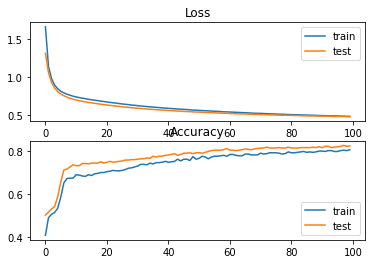

In [30]:
# evaluate model behavior
summarize_model(model, history, trainX, trainy, testX, testy)

Now that we have a baseline of performance and learning dynamics for an MLP on Problem 2, we can see how transfer learning affects MLP.

### MLP With Transfer Learning for Problem 2

The model that was fit on Problem 1 can be loaded, and the weights can be used as the initial weights for a model fit on Problem 2. This type of transfer learning is where learning on a different but related problem is used as a weight initialization scheme. This requires that the fit_model() function be updated to load the model and refit it on examples for Problem 2. The model saved in model.h5 can be loaded using the load_model() Keras function.

In [32]:
from tensorflow.keras.models import load_model

# load model
model = load_model('model.h5')

Once loaded, the model can be compiled and fit as per normal. The updated fit model() with this change is listed below.

In [33]:
# load and re-fit model on a training dataset
def fit_model(trainX, trainy, testX, testy):
    # load model
    model = load_model('model.h5')

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # re-fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

    return model, history

We would expect that a model that uses the weights from a model fit on a different but related problem to learn the problem perhaps faster in terms of the learning curve and perhaps result in lower generalization error, although these aspects would be dependent on the choice of problems and model. For completeness, the full example of this change is listed below.

In [34]:
# transfer learning with mlp model on problem 2
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib import pyplot

# prepare a blobs examples with a given random seed
def samples_for_seed(seed):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    
    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]

    return trainX, trainy, testX, testy

# load and re-fit model on a training dataset
def fit_model(trainX, trainy, testX, testy):
    # load model
    model = load_model('model.h5')

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # re-fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

    
    return model, history
# summarize the performance of the fit model
def summarize_model(model, history, trainX, trainy, testX, testy):
    # evaluate the model
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # plot loss during training
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    
    pyplot.show()

# prepare data
trainX, trainy, testX, testy = samples_for_seed(2)
# fit model on train dataset
model, history = fit_model(trainX, trainy, testX, testy)

Running the example fits and evaluates the model's performance, printing the classification accuracy on the train and test sets.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved a lower generalization error, achieving an accuracy of about 81% on the test dataset for Problem 2 compared to the standalone model that achieved about 79% accuracy.

A  figure is also created summarizing the learning curves of the model. In this case, we can see that the model does appear to have a similar learning curve, although we do see apparent improvements in the learning curve for the test set (orange line) both in terms of better performance earlier (epoch 20 onward) and above the performance of the model on the training set.

Train: 0.808, Test: 0.818


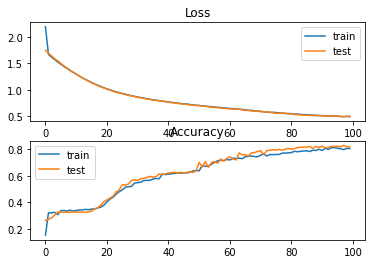

In [35]:
# evaluate model behavior
summarize_model(model, history, trainX, trainy, testX, testy)

We have only looked at single runs of a standalone MLP model and an MLP with transfer learning. Neural network algorithms are stochastic, therefore an average of performance across multiple runs is required to see if the observed behavior is real or a statistical fluke.

### Comparison of Models on Problem 2

To determine whether transfer learning for the blobs multiclass classification problem has a real effect, we must repeat each experiment multiple times and analyze the average performance across the repeats. We will compare the standalone model
trained on Problem 2 to a model using transfer learning, averaged over 30 repeats. Further, we will investigate whether keeping the weights in some of the layers fixed improves model performance. The model trained on Problem 1 has two hidden layers. By keeping the first or the first and second hidden layers fixed, the layers with unchangeable weights will act as a feature extractor and may provide features that make learning Problem 2 easier, affecting the speed of learning and/or the model's accuracy on the test set. As the first step, we will simplify the fit_model() function to fit the model and discard any training history to focus on the final accuracy of the trained model.

In [36]:
# define and fit model on a training dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)

    return model

Next, we can develop a function that will repeatedly fit a new standalone model on Problem 2 on the training dataset and evaluate accuracy on the test set. The eval_standalone_model() function below implements this, taking the train and test sets as arguments and the number of repeats and returns a list of accuracy scores for models on the test dataset.

In [37]:
# repeated evaluation of a standalone model
def eval_standalone_model(trainX, trainy, testX, testy, n_repeats):
    scores = list()
    for _ in range(n_repeats):
        # define and fit a new model on the train dataset
        model = fit_model(trainX, trainy)
        
        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)

    return scores

Summarizing the distribution of accuracy scores returned from this function will give an idea of how well the chosen standalone model performs on Problem 2.

In [45]:
from numpy import mean, std

# repeated evaluation of standalone model
standalone_scores = eval_standalone_model(trainX, trainy, testX, testy, 30)
print('Standalone %.3f (%.3f)' % (mean(standalone_scores), std(standalone_scores)))

Standalone 0.767 (0.117)


Next, we need an equivalent function for evaluating a model using transfer learning. In each loop, the model trained on Problem 1 must be loaded from file, fit on the training dataset for Problem 2, then evaluated on the test set for Problem 2. In addition, we will configure 0, 1, or 2 of the hidden layers in the loaded model to remain fixed. Keeping 0 hidden layers fixed means that all of the weights in the model will be adapted when learning Problem 2, using transfer learning as a weight initialization scheme. Whereas, keeping both (2) of the hidden layers fixed means that only the output layer of the model will be adapted during training, using transfer learning as a feature extraction method.

The eval transfer model() function below implements this, taking the train and test datasets for Problem 2 as arguments, the number of hidden layers in the loaded model to keep fixed, and the number of times to repeat the experiment. The function returns a list of test accuracy scores, and summarizing this distribution will give a reasonable idea of how well the model with the chosen type of transfer learning performs on Problem 2.

In [40]:
# repeated evaluation of a model with transfer learning
def eval_transfer_model(trainX, trainy, testX, testy, n_fixed, n_repeats):
    scores = list()
    for _ in range(n_repeats):
        # load model
        model = load_model('model.h5')
        
        # mark layer weights as fixed or not trainable
        for i in range(n_fixed):
            model.layers[i].trainable = False
        
        # re-compile model
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        # fit model on train dataset
        model.fit(trainX, trainy, epochs=100, verbose=0)

        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)
    
    return scores

We can call this function repeatedly, setting n fixed to 0, 1, 2 in a loop and summarizing performance as we go; for example:

In [43]:
# repeated evaluation of transfer learning model, vary fixed layers
n_fixed = 3
for i in range(n_fixed):
    scores = eval_transfer_model(trainX, trainy, testX, testy, i, 30)
    print('Transfer (fixed=%d) %.3f (%.3f)' % (i, mean(scores), std(scores)))

Transfer (fixed=0) 0.822 (0.009)
Transfer (fixed=1) 0.775 (0.014)
Transfer (fixed=2) 0.763 (0.021)


In addition to reporting each model's mean and standard deviation, we can collect all scores and create a box and whisker plot to summarize and compare the distributions of model scores. Tying all of these elements together, the complete example is listed below.

Standalone 0.795 (0.079)
Transfer (fixed=0) 0.825 (0.004)
Transfer (fixed=1) 0.773 (0.015)
Transfer (fixed=2) 0.765 (0.022)


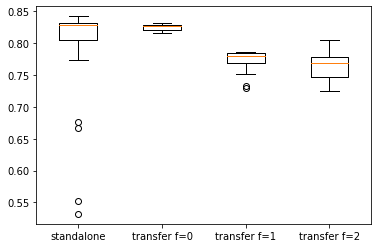

In [46]:
# compare standalone mlp model performance to transfer learning
from sklearn.datasets import make_blobs
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy import mean, std

# prepare a blobs examples with a given random seed
def samples_for_seed(seed):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)

    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]

    return trainX, trainy, testX, testy

# define and fit model on a training dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=100, verbose=0)

    return model

# repeated evaluation of a standalone model
def eval_standalone_model(trainX, trainy, testX, testy, n_repeats):
    scores = list()
    for _ in range(n_repeats):
        # define and fit a new model on the train dataset
        model = fit_model(trainX, trainy)

        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)
    
    return scores

# repeated evaluation of a model with transfer learning
def eval_transfer_model(trainX, trainy, testX, testy, n_fixed, n_repeats):
    scores = list()
    for _ in range(n_repeats):
        # load model
        model = load_model('model.h5')

        # mark layer weights as fixed or not trainable
        for i in range(n_fixed):
            model.layers[i].trainable = False

        # re-compile model
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        # fit model on train dataset
        model.fit(trainX, trainy, epochs=100, verbose=0)

        # evaluate model on test dataset
        _, test_acc = model.evaluate(testX, testy, verbose=0)
        scores.append(test_acc)

    return scores

# prepare data for problem 2
trainX, trainy, testX, testy = samples_for_seed(2)
n_repeats = 30
dists, dist_labels = list(), list()

# repeated evaluation of standalone model
standalone_scores = eval_standalone_model(trainX, trainy, testX, testy, n_repeats)
print('Standalone %.3f (%.3f)' % (mean(standalone_scores), std(standalone_scores)))
dists.append(standalone_scores)
dist_labels.append('standalone')

# repeated evaluation of transfer learning model, vary fixed layers
n_fixed = 3
for i in range(n_fixed):
    scores = eval_transfer_model(trainX, trainy, testX, testy, i, n_repeats)
    print('Transfer (fixed=%d) %.3f (%.3f)' % (i, mean(scores), std(scores)))
    dists.append(scores)
    dist_labels.append('transfer f='+str(i))

# box and whisker plot of score distributions
pyplot.boxplot(dists, labels=dist_labels)
pyplot.show()

Running the example first reports the mean and standard deviation of classification accuracy on the test dataset for each model.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the standalone model achieved an accuracy of about 78% on Problem 2 with a large standard deviation of 10%. In contrast, we can see that the transfer learning models' spread is much smaller, ranging from about 0.05% to 1.5%.

This difference in the standard deviations of the test accuracy scores shows the stability that transfer learning can bring to the model, reducing the variance in the performance of the final model introduced via the stochastic learning algorithm. Comparing the mean test accuracy of the models, we can see that transfer learning that used the model as a weight initialization scheme (fixed=0) resulted in better performance than the standalone model with about 80% accuracy. Keeping all hidden layers fixed (fixed=2) and using them as a feature extraction scheme resulted in worse performance on average than the standalone model. It suggests that the approach is too restrictive in this case.

Interestingly, we see the best performance when the first hidden layer is kept fixed (fixed=1), and the second hidden layer is adapted to the problem with a test classification accuracy of about 81%. This suggests that, in this case, the problem benefits from both the feature extraction and weight initialization properties of transfer learning. It may be interesting to see how the results of this last approach compare to the same model where the weights of the second hidden layer (and perhaps the output layer) are re-initialized with random numbers. This comparison would demonstrate whether the feature extraction properties of transfer learning alone or feature extraction and weight initialization properties are beneficial.

A figure is created showing four box and whisker plots. The box shows the middle 50% of each data distribution, the orange line shows the median, and the dots show outliers. The box and whisker plot for the standalone model shows a number of outliers, indicating that the model performs well on average, but there is a chance that it can perform very poorly. Conversely, we see that the behavior of the models with transfer learning is more stable, showing a tighter distribution in performance.

**Extensions**

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Reverse Experiment**. Train and save a model for Problem 2 and see if it can help with transfer learning on Problem 1.
* **Add Hidden Layer**. Update the example to keep both hidden layers fixed, but add a new hidden layer with randomly initialized weights after the fixed layers before the output layer and compare performance.
* **Randomly Initialize Layers**. Update the example to randomly initialize the weights of the second hidden layer and the output layer and compare performance.

**Summary**

In this tutorial, you discovered how to use transfer learning to improve the performance of deep learning neural networks in Python with Keras. Specifically, you learned:

* Transfer learning is a method for reusing a model trained on a related predictive modeling problem.
* Transfer learning can accelerate the training of neural networks as either a weight initialization scheme or feature extraction method.
* How to use transfer learning to improve the performance of an MLP for a multiclass classification problem.